In [1]:

from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.dslices.exper_handler import ExperHandlerEnsemble
from common.dslices.config import config

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. 
TEST_FOLD = 0

seg_exper_handler = seg_exper_ensemble.seg_exper_handlers[TEST_FOLD]

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [3]:
def prepare(exper_hdl, patient_id=None, type_of_map="emap", force_reload=False):
    
    if type_of_map == "emap":
        _ = exper_hdl.get_pred_prob_maps(patient_id=patient_id, mc_dropout=False)
        exper_hdl.get_pred_labels(patient_id=patient_id)
        exper_hdl.get_entropy_maps(patient_id=patient_id, force_reload=force_reload)
    else:
        exper_hdl.get_referral_maps(0.001, per_class=False, aggregate_func="max", use_raw_maps=True,
                          patient_id=patient_id, load_ref_map_blobs=False)
        
        _ = exper_hdl.get_pred_labels(patient_id=patient_id, mc_dropout=True)
        
    if exper_hdl.dt_maps is None or len(exper_hdl.dt_maps) == 0 or force_reload:
        exper_hdl.get_dt_maps(patient_id=patient_id, force_reload=force_reload)
        
    if exper_hdl.test_set is None:
        exper_hdl.get_test_set()
    
patient_id = "patient100"
prepare(seg_exper_handler, patient_id, type_of_map="emap", force_reload=True)

  8%|▊         | 2/25 [00:00<00:01, 13.14it/s]

INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 14.50it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


In [17]:
from utils.detector.generate_dt_maps import generate_dt_maps

_ = generate_dt_maps(seg_exper_handler, patient_id=patient_id)
    

Penalty 491.01
Penalty 491.01
Penalty 491.01
Penalty 491.01
Penalty 491.01
Penalty 491.01


In [6]:
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion, \
    generate_binary_structure
    
def auto_pred_border(reference, connectivity=1):
    reference = np.atleast_1d(reference.astype(np.bool))
    # binary structure
    footprint = generate_binary_structure(reference.ndim, connectivity)
    if 0 == np.count_nonzero(reference):
        raise RuntimeError('The reference array does not contain any binary object.')

    reference_border = np.logical_xor(reference, binary_erosion(reference, structure=footprint, iterations=1))
    return reference_border

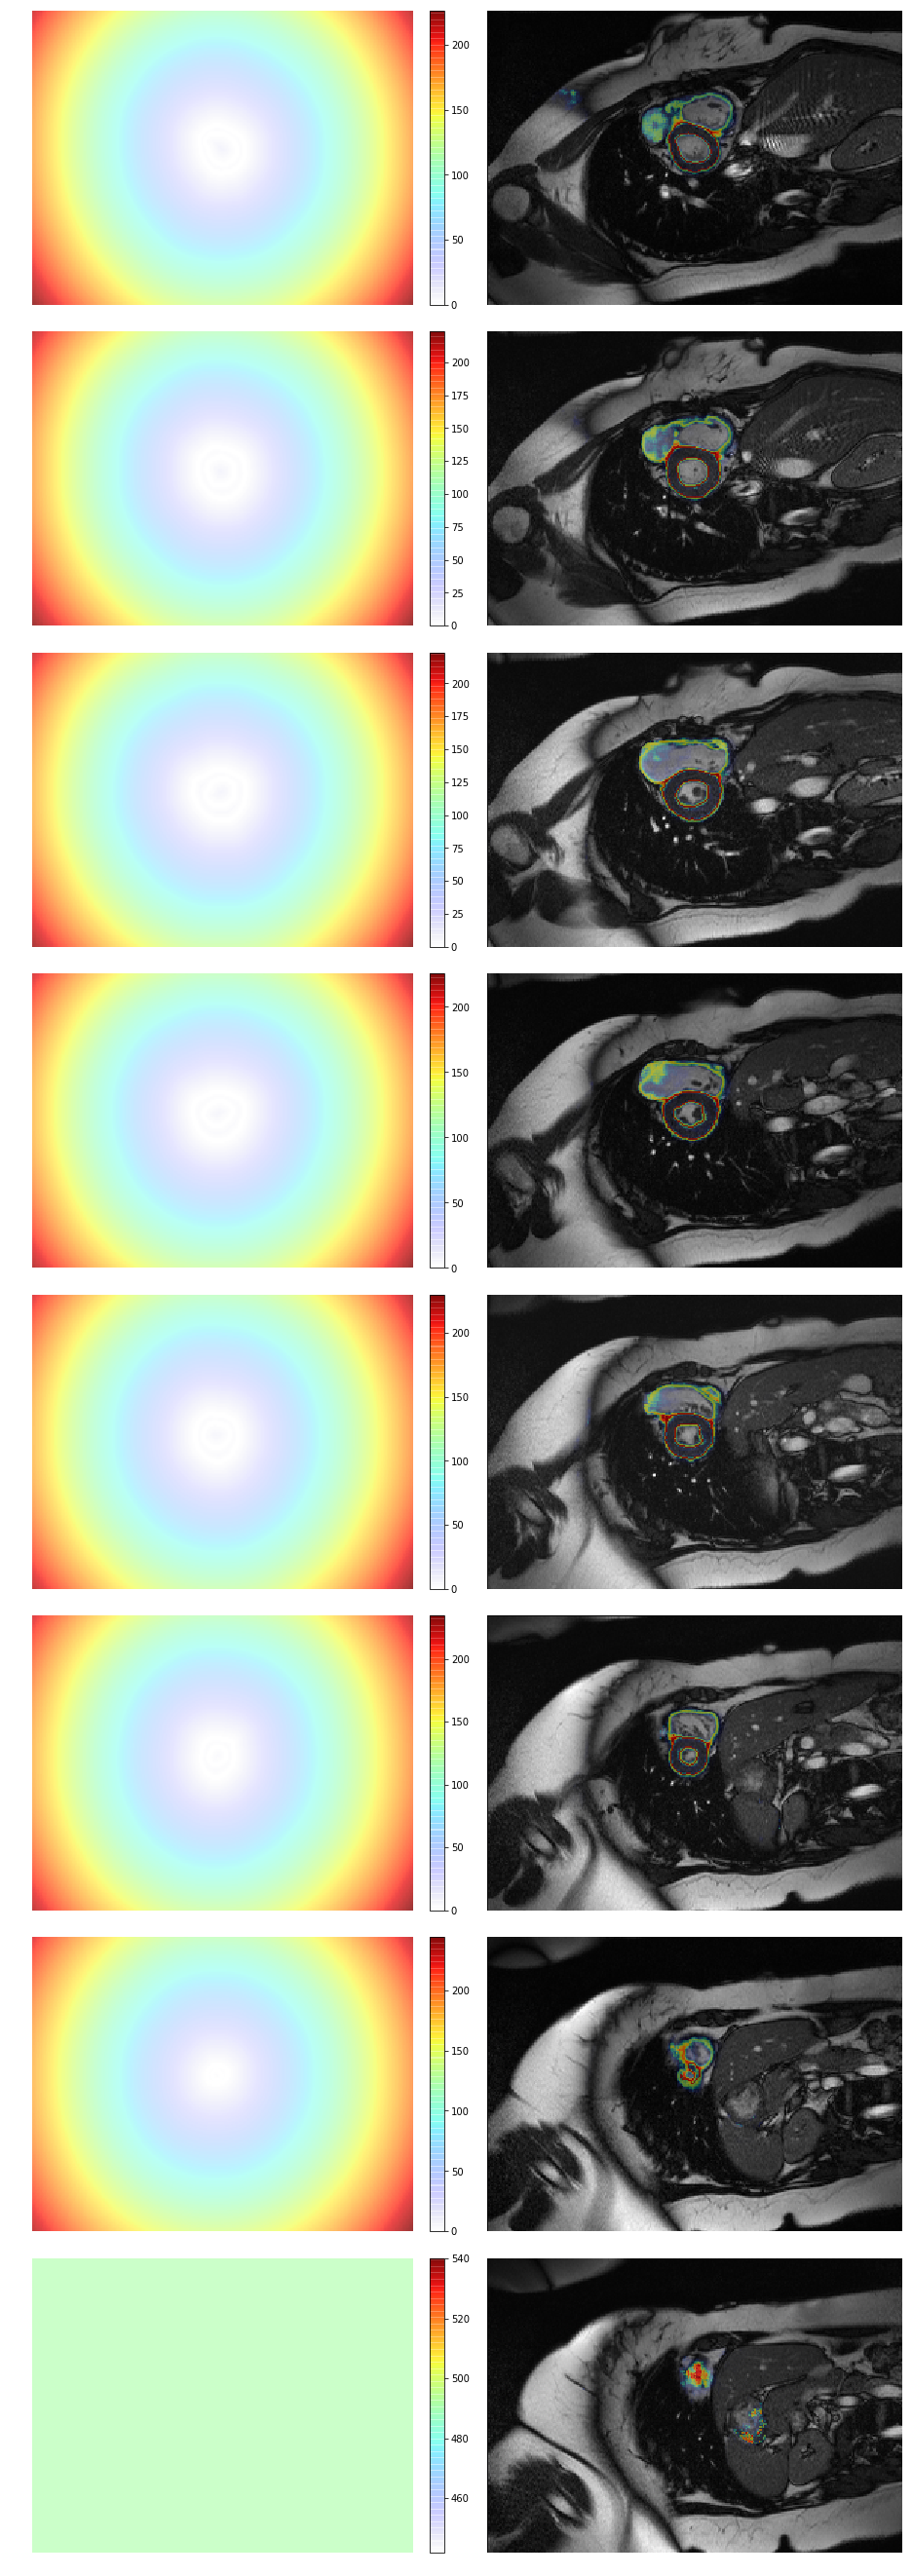

In [20]:
image, labels = seg_exper_handler.test_set.get_test_pair(patient_id)

batch_size = image.shape[3]

width = 16
height = batch_size * 6
columns = 4
rows = batch_size * 2
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

phase = 0
target_class = 2
cls_offset = phase * 4
cls_idx = cls_offset + target_class

for idx in np.arange(batch_size):
    image_with_padding = image[phase, :, :, idx]
    image_slice = ACDC2017DataSet.remove_padding(image_with_padding)
    auto_pred = seg_exper_handler.pred_labels[patient_id]
    auto_pred_slice = auto_pred[cls_idx, :, :, idx]
    if 0 != np.count_nonzero(auto_pred_slice):
        auto_pred_slice_border = auto_pred_border(auto_pred_slice)
    reference_slice = labels[cls_idx, :, :, idx]
    umap = seg_exper_handler.entropy_maps[patient_id]
    umap_slice = umap[phase, :, :, idx]
    dt_slices = seg_exper_handler.get_dt_maps(patient_id)
    dt_slice = dt_slices[cls_idx, :, : , idx]
    # negative_idx = dt_slice <= 0
    # dt_slice[negative_idx] = -20
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    # ax1.imshow(image_slice, cmap=cm.gray)
    # ax1.imshow(reference_slice, cmap=mycmap)
    ax1_dt_plot = ax1.imshow(dt_slice, cmap=mycmap)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image_slice, cmap=cm.gray)
    ax2.imshow(umap_slice, cmap=mycmap)
    
    if 0 != np.count_nonzero(auto_pred_slice):
        ax2_dt_plot = ax2.imshow(auto_pred_slice_border, cmap=mycmap)
    ax1.set_aspect('auto')
    fig.colorbar(ax1_dt_plot, ax=ax1, fraction=0.046, pad=0.04)
    plt.axis("off")
    row += 2